In [129]:
import anndata
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
import numpy as np
import statsmodels.api as sm
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import scanpy as sc

In [108]:
data_10x = anndata.read_h5ad('processed_10x.h5ad')
data_polyT = anndata.read_h5ad('processed_polyT.h5ad')
data_randO = anndata.read_h5ad('processed_randO.h5ad')

In [130]:
def compare_genes(data_x, data_y, x_name = 'x', y_name = 'y'):
    shared_genes = list(set(data_y.var_names).intersection(set(data_x.var_names)))
    shared_data = data_x.var.loc[shared_genes, 'percent_counts'].copy().to_frame()
    shared_data.rename(columns={'percent_counts': x_name + '_percent_counts'}, inplace=True)
    shared_data[y_name + '_percent_counts'] = data_y.var.loc[shared_genes, 'percent_counts'].values
    shared_data.sort_values(by=x_name + '_percent_counts', inplace=True)

    #fit linear regression model
    model = sm.OLS(shared_data[y_name + '_percent_counts'], shared_data[x_name + '_percent_counts']).fit() 
    np.set_printoptions(suppress=True) # suppress scientific notation
    shared_data['cooks_distance'] = model.get_influence().cooks_distance[0]

    return shared_data

def scatter_genes(fig, ax, shared_data, x_name = 'x', y_name = 'y',  xlim = None, ylim = None, norm = "log"):
    #Calculate correlation
    pearson_r = pearsonr(shared_data[x_name + '_percent_counts'], shared_data[y_name + '_percent_counts']).correlation
    spearman_r = spearmanr(shared_data[x_name + '_percent_counts'], shared_data[y_name + '_percent_counts']).correlation

    plot = ax.scatter(shared_data[x_name + '_percent_counts'], 
                shared_data[y_name + '_percent_counts'], 
                norm = norm, 
                alpha=0.5, 
                s=50, 
                c=shared_data['cooks_distance'], 
                cmap='viridis')
    
    ax.set_xlabel(x_name + ' Gene Percent Count')
    ax.set_ylabel(y_name + ' Gene Percent Count')
    if xlim:
        ax.set_xlim(0, xlim)
    if ylim:
        ax.set_ylim(0, ylim)

    textstr = '\n'.join((
    r'$\mathrm{r}=%.2f$' % (pearson_r, ),
    r'$\rho=%.2f$' % (spearman_r, )))
    ax.text(0.05, 0.87, textstr, transform = ax.transAxes, fontsize = 12)

    return plot

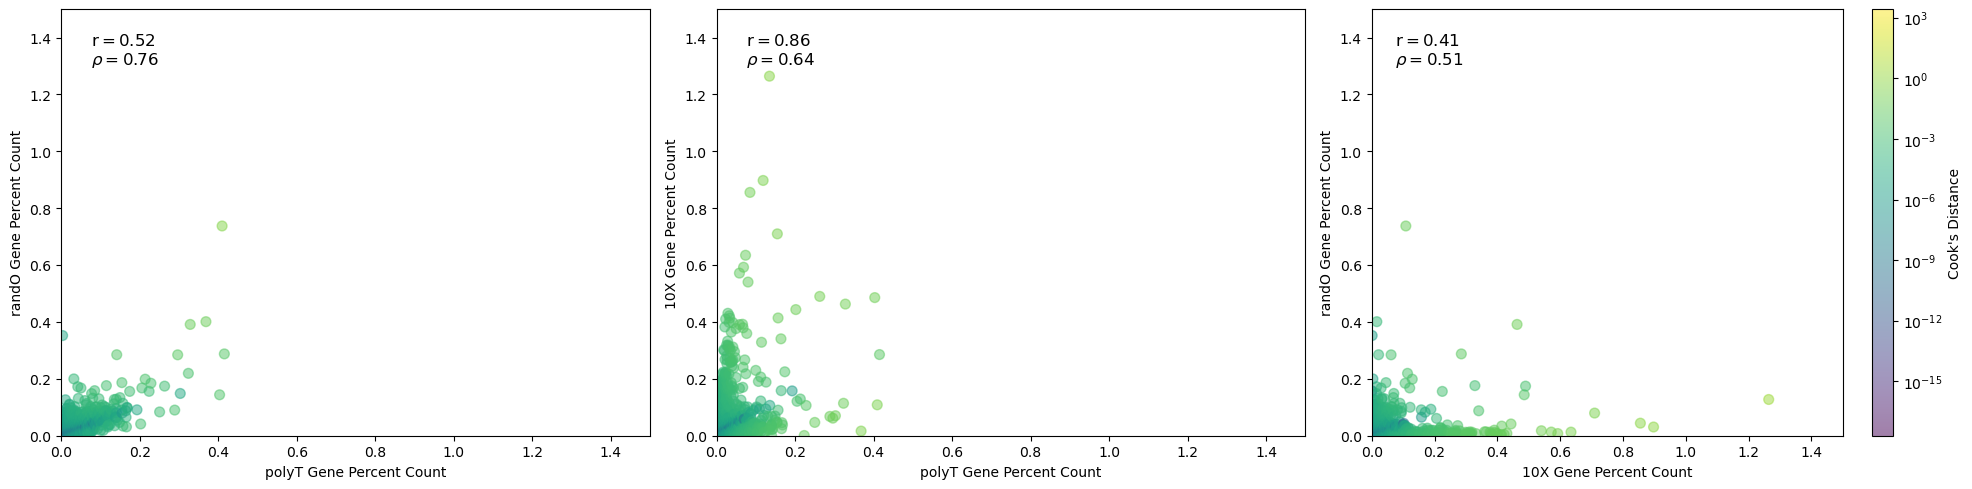

In [131]:
fig, axs = plt.subplots(1, 3, figsize = (20, 5))

xlim = 1.5
ylim = 1.5

TvO_genes = compare_genes(data_polyT, data_randO, x_name = 'polyT', y_name = 'randO')
TvX_genes = compare_genes(data_polyT, data_10x, x_name = 'polyT', y_name = '10X')
XvO_genes = compare_genes(data_10x, data_randO, x_name = '10X', y_name = 'randO')

c_values = TvO_genes['cooks_distance'].tolist() + TvX_genes['cooks_distance'].tolist() + XvO_genes['cooks_distance'].tolist()
norm = LogNorm(min(c_values), max(c_values))

scatter_genes(fig, axs[0], TvO_genes, x_name = 'polyT', y_name = 'randO', xlim=xlim, ylim=ylim, norm=norm)
scatter_genes(fig, axs[1], TvX_genes, x_name = 'polyT', y_name = '10X', xlim=xlim, ylim=ylim,norm=norm)
plot = scatter_genes(fig, axs[2], XvO_genes, x_name = '10X', y_name = 'randO', xlim=xlim, ylim=ylim,norm=norm)

fig.colorbar(plot, label = "Cook's Distance")

plt.tight_layout()
plt.show()

In [119]:
for shared_data in [TvO_genes, TvX_genes, XvO_genes]:
    shared_data.sort_values(by='cooks_distance', ascending=False, inplace=True)
    print("Top 10 outliers based on Cook's distance:", shared_data.index[:10].tolist())

Top 10 outliers based on Cook's distance: ['Malat1', 'Lars2', 'Grip2', 'Macf1', 'mt-Co1', 'Ddx5', 'Xist', 'Myh9', 'Ptma', 'Srrm2']
Top 10 outliers based on Cook's distance: ['Malat1', 'mt-Co3', 'Macf1', 'Tmsb4x', 'Grip2', 'mt-Atp6', 'Actb', 'mt-Co2', 'mt-Co1', 'Ptma']
Top 10 outliers based on Cook's distance: ['Malat1', 'mt-Co3', 'Tmsb4x', 'mt-Co2', 'Rps8', 'mt-Atp6', 'Rpl13', 'Trbc2', 'Tpt1', 'mt-Co1']


In [124]:
genes_10x = data_10x.var
top_10x = genes_10x.sort_values(by='n_cells',ascending=False).head(10).index.tolist()

genes_polyT = data_polyT.var
top_polyT = genes_polyT.sort_values(by='n_cells',ascending=False).head(10).index.tolist()

print("Top 10 genes in 10x data:")
print(top_10x)
print()
print("Top 10 genes in parse data:")
print(top_polyT)

Top 10 genes in 10x data:
['Malat1', 'mt-Co3', 'mt-Co2', 'mt-Atp6', 'Tmsb4x', 'Trbc2', 'mt-Co1', 'Tpt1', 'Actb', 'mt-Cytb']

Top 10 genes in parse data:
['Malat1', 'Grip2', 'Macf1', 'Xist', 'Ptprc', 'Prrc2c', 'mt-Co1', 'Rbm25', 'Ddx5', 'Atrx']


In [125]:
common_genes = data_10x.var_names.intersection(data_polyT.var_names)
print("num common genes: " + str(common_genes.shape[0]))
print("num 10x genes: " + str(data_10x.var_names.shape[0]))
print("num parse genes: " + str(data_polyT.var_names.shape[0]))

num common genes: 9806
num 10x genes: 13548
num parse genes: 10107


In [127]:
top_thousand_10x = genes_10x.sort_values(by='n_cells',ascending=False).head(1000)
top_thousand_polyT = genes_polyT.sort_values(by='n_cells',ascending=False).head(1000)

print("Number of shared genes from top 1000 genes for each method: " + str(len(top_thousand_10x.index.intersection(top_thousand_polyT.index))))

Number of shared genes from top 1000 genes for each method: 442
